In [1]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import time

sns.set(font_scale=1.3)

In [2]:
def show_opencv_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')


def compute_borders(array):
    iszero = np.concatenate(([0], np.equal(array, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    start, end = np.where(absdiff == 1)[0].reshape(-1, 2).T
    return start, end


def ratio_check(pattern_start, pattern_end):
    patten_width = pattern_end[-1] - pattern_start[0]
    if patten_width < 7:
        return False
    
    module_width = np.ceil(patten_width / 7)
    max_variance = module_width / 2
    
    b1_size = pattern_end[0] - pattern_start[0]
    b2_size = pattern_end[1] - pattern_start[1]
    b3_size = pattern_end[2] - pattern_start[2]

    w1_size = pattern_start[1] - pattern_end[0]
    w2_size = pattern_start[2] - pattern_end[1]
    
    f = lambda x: np.abs(x - module_width) < max_variance
    g = lambda x: np.abs(x - 3 * module_width) < 3 * max_variance
    
    return f(b1_size) and f(b3_size) and f(w1_size) and f(w2_size) and g(b2_size)


def cross_check(row_pattern, column_pattern):
    row_pattern_start, row_pattern_end = row_pattern
    column_pattern_start, column_pattern_end = column_pattern
    
    row_width = row_pattern_end[-1] - row_pattern_start[0]
    column_width = column_pattern_end[-1] - column_pattern_start[0]
    flag = 5 * np.abs(column_width - row_width) < 2 * row_width
    
    b2_size = row_pattern_end[1] - row_pattern_start[1]
    
    b1_size = column_pattern_end[0] - column_pattern_start[0]
    b3_size = column_pattern_end[2] - column_pattern_start[2]

    w1_size = column_pattern_start[1] - column_pattern_end[0]
    w2_size = column_pattern_start[2] - column_pattern_end[1]
    
    return flag and b1_size < b2_size and b3_size < b2_size and w1_size < b2_size and w2_size < b2_size


def check_array(row_pattern, column, row_number):
    start, end = compute_borders(column)
    
    idx = np.where((start <= row_number) & (row_number <= end))[0]
    if len(idx)== 0:
        return False, None

    assert len(idx) == 1
    idx = idx[0]
    if idx == 0:
        return False, None

    column_pattern = start[idx-1:idx+2], end[idx-1:idx+2]
    if len(column_pattern[0]) == 3:
        row_center = (column_pattern[0][0] + column_pattern[1][-1]) // 2
        return ratio_check(*column_pattern) and cross_check(row_pattern, column_pattern), row_center
    else:
        return False, None
    
    
def get_diagonal(mask, x, y):
    x_start = x - min(x, y)
    y_start = y - min(x, y)

    diff = min(mask.shape[0] - x, mask.shape[1] - y)
    x_end, y_end = x + diff, y + diff

    coords = np.vstack((np.arange(x_start, x_end), np.arange(y_start, y_end))).T
    idx = np.where((coords == [x, y]).all(axis=1))[0][0]
    diagonal = mask[coords[:, 0], coords[:, 1]]
    return diagonal, idx


def add_candidate(candidates, new_candidate):
    new_x, new_y, new_width = new_candidate
    found = False
    
    for i, candidate in enumerate(candidates):
        x, y, width = candidate
        
        dist = np.sqrt((x - new_x) ** 2 + (y - new_y) ** 2)
        if dist < 10:
            x, y, width = (x + new_x) / 2, (y + new_y) / 2, (width + new_width) / 2
            candidates[i] = (x, y, width)
            found = True
            break
            
    if not found:
        candidates.append((new_x, new_y, new_width))
        
    return candidates


def find_patterns(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.adaptiveThreshold(gray, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 0).astype(int)
    
    candidates = []
    for row_number, row in tqdm(enumerate(mask), total=len(mask)):
        start, end = compute_borders(row)

        if len(start) >= 3:
            for j in range(len(start) - 2):
                pattern_start, pattern_end = start[j:j+3], end[j:j+3]

                if ratio_check(pattern_start, pattern_end):
                    column_center = (pattern_start[0] + pattern_end[-1]) // 2
                    check, row_center = check_array((pattern_start, pattern_end), mask[:, column_center], row_number)

                    if not check:
                        continue

                    check, column_center = check_array((pattern_start, pattern_end), mask[row_center], column_center)

                    if not check:
                        continue

                    diagonal, idx = get_diagonal(mask, row_center, column_center)
                    check, _ = check_array((pattern_start, pattern_end), diagonal, idx)
                    if check:
                        width = pattern_end[-1] - pattern_start[0]
                        candidates = add_candidate(candidates, (row_center, column_center, width))

    candidates = np.array(candidates).astype(int)
    return candidates


def draw_patterns(image, patterns):
    for pattern in patterns:
        x, y, width = pattern
        start_point, end_point = (x - width // 2, y - width // 2), (x + width // 2, y + width // 2)
        image = cv2.rectangle(image, start_point[::-1], end_point[::-1], (0, 255, 0), 10)
        
    return image

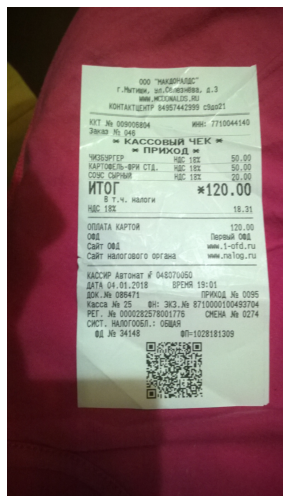

In [3]:
pathes = [os.path.join('./data/TestSet1', path) for path in os.listdir('./data/TestSet1')]
image = cv2.imread(pathes[1])

plt.figure(figsize=(16, 9))
show_opencv_image(image)
plt.show()

In [4]:
start = time.time()
patterns = find_patterns(image)
end = time.time() - start
print(f'время: {np.round(end, 1)}c')

  0%|          | 0/3552 [00:00<?, ?it/s]

12.7

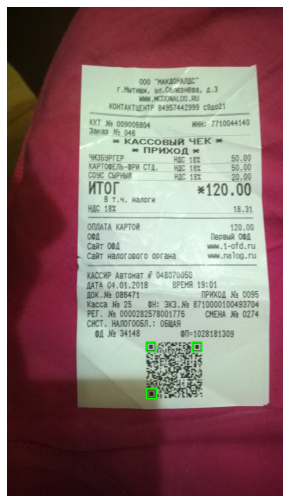

In [5]:
edited_image = draw_patterns(image.copy(), patterns)

plt.figure(figsize=(16, 9))
show_opencv_image(edited_image)
plt.show()

In [6]:
data1 = [
    [3, 1, 0],
    [3, 0, 0],
    [3, 0, 0],
    [3, 0, 0],
    [3, 0, 0],
    [2, 1, 0],
    [3, 0, 0],
    [2, 1, 1],
    [3, 1, 0],
    [3, 0, 0],
    [3, 0, 0],
    [3, 0, 0],
    [3, 0, 0],
    [3, 1, 0],
    [2, 0, 1],
    [3, 0, 0],
    [2, 0, 1],
    [3, 1, 0],
    [1, 0, 2],
    [1, 1, 2],
    [0, 0, 3],
    [1, 1, 2],
    [2, 0, 1],
    [2, 0, 1],
    [1, 1, 2],
    [3, 0, 0],
    [2, 0, 1],
    [2, 0, 1],
    [3, 0, 0],
    [3, 0, 0],
    [3, 0, 0],
    [1, 1, 2],
    [1, 0, 2],
    [3, 0, 0],
    [3, 0, 0],
    [2, 0, 1],
    [0, 0, 3],
    [3, 0, 0],
    [6, 1, 0],
    [3, 0, 0],
    [3, 1, 0],
    [3, 1, 0],
    [3, 0, 0],
    [3, 1, 0],
    [2, 2, 1],
    [3, 2, 0],
    [3, 1, 0]
]

assert len(data1) == 47

In [7]:
data2 = [
    [0, 2, 3],
    [0, 0, 3],
    [3, 2, 0],
    [0, 1, 3],
    [2, 0, 1],
    [2, 0, 1],
    [3, 1, 0],
    [1, 1, 2],
    [2, 0, 1],
    [3, 0, 0],
    [0, 1, 3],
    [6, 0, 0],
    [3, 1, 0],
    [1, 0, 2],
    [2, 0, 1],
    [2, 0, 1],
    [2, 1, 1],
    [1, 0, 2],
    [2, 0, 1],
    [2, 1, 1],
    [0, 1, 3],
    [1, 0, 2],
    [2, 0, 1],
    [1, 0, 2],
    [3, 0, 0],
    [2, 1, 1],
    [1, 0, 2],
    [3, 0, 0],
    [1, 0, 2],
    [3, 0, 0],
    [3, 0, 0],
    [2, 0, 1],
    [3, 0, 0],
    [2, 0, 1],
    [2, 0, 1],
    [2, 0, 1],
    [3, 0, 0],
    [3, 0, 0],
    [3, 0, 0],
    [2, 0, 1],
    [0, 0, 3],
    [2, 0, 1],
    [0, 0, 3],
    [3, 0, 0],
    [2, 0, 1],
    [1, 0, 2],
    [2, 0, 1],
    [2, 2, 1]
]

assert len(data2) == 48

In [8]:
import pandas as pd

df1 = pd.DataFrame(data1, columns=['TP', 'FP', 'FN'])
df2 = pd.DataFrame(data2, columns=['TP', 'FP', 'FN'])

TP, FP, FN = df1.sum() + df2.sum()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print(f'precision: {np.round(precision * 100, 2)}, recall: {np.round(recall * 100, 2)}')

precision: 85.89, recall: 71.38
